# Dimensionality Reduction 

In this part, the goal is to find a suitable low-dimensional representation of a dataset. Our focus will be on the following tools:

* Principal component analysis 
* Isomap
* Diffusion Maps

We will also use Tensorboards for data visualization at the end. We use two dataset, MNIST and Swiss Roll. We have introduced MNIST previously. We now introduce Swiss Roll. We use sklearn package for that purpose.


In [1]:
from sklearn.datasets import make_swiss_roll as sroll
n_samples = 1500
noise = 0
X, color = sroll(n_samples, noise=noise)

Let's plot the data and see how it looks like.

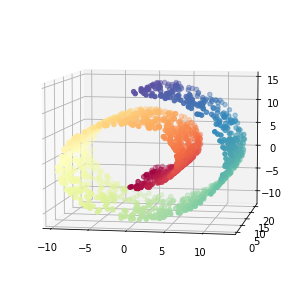

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2],'o',c=color, cmap=plt.cm.Spectral)
plt.show()

This dataset is an example of data model with non-linear structure. More precisely the data lives on a  manifold and the goal is to exactly learn that.

## Dimensionality Reduction for Swiss Roll

We now try to apply our algorithms to find a suitable representation of Swiss Roll in two-dimensional space. We measure the run time of each algorithm as well.

In [3]:
from time import time

### PCA

We first run the PCA algorithm from sklearn package and then compare it with our own implementation.

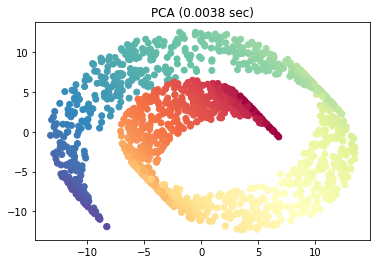

In [4]:
from sklearn.decomposition import PCA
t0pca = time()
XPCA = PCA(n_components=2).fit_transform(X)
t1pca = time()
plt.scatter(XPCA[:, 0], XPCA[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("PCA (%.2g sec)" % (t1pca - t0pca))
plt.show()

To implement PCA the sample covariance matix of the data should be formed. We first import linear algebra package from python.

In [5]:
import numpy as np
from numpy import linalg as la

Here are the main steps:

* The sample covariance matrix is found using a simple command. 
* Spectral decomposition of the sample covariance matrix is found.
* The top eigenvectors are chosen and the projection matrix is formed.

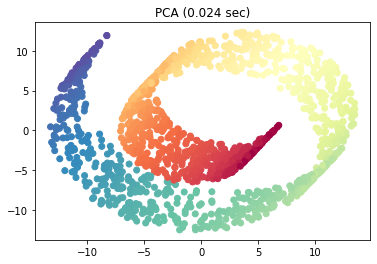

In [6]:
t0pca = time()
sampleCov = np.cov(X.T)
eigvalCov, eigvecCov = la.eig(sampleCov)
idx = eigvalCov.argsort()[::-1]   
eigvalCov = eigvalCov[idx]
eigvecCov = eigvecCov[:,idx]

## Finding the projection matrx
n = n_samples
Qproj = eigvecCov[:,[0,1]]
En = np.eye(n)-np.ones((n,n))/n # Centering matrix

## This is one way of finding PCA
XPCA = (Qproj.T@X.T@En).T
t1pca = time()
plt.scatter(XPCA[:, 0], XPCA[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("PCA (%.2g sec)" % (t1pca - t0pca))
plt.show()

### Isomap

Isomap is a manifold learning algorithm. In this example we construct the underlying graph using 10 nearest neighbors.

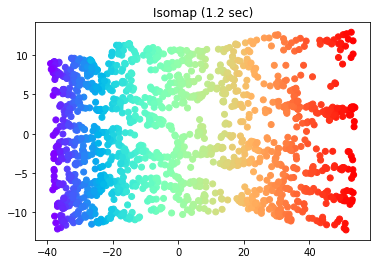

In [7]:
from sklearn import manifold
n_neighbors = 10
t0iso = time()
XISO = manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(X).T
t1iso = time()


plt.scatter(XISO[0], XISO[1], c=color, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ('Isomap', t1iso - t0iso))
plt.axis('tight')
plt.show()

### Diffusion Maps

Diffusion maps are another example of non-linear dimensionality reduction algorithm. They do not have an embeded implementation inside python so we use our own development here. 

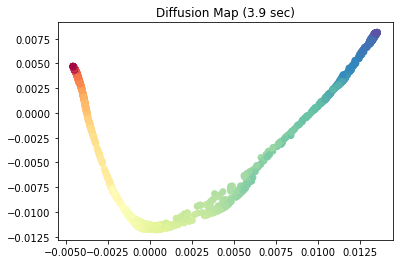

In [8]:
from diffusionmapmod import diffusionmap as Diff

eps = 6
t = 10
k = 2
t0diff = time()
XDM = Diff(X,n_samples,eps,t,k).T
t1diff = time()

plt.scatter(XDM[:, 0], XDM[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Diffusion Map (%.2g sec)" % (t1diff - t0diff))
plt.show()

### t-SNE

 t-distributed stochastic neighbor embedding (t-SNE) is another dimensionality reduction algorithm which is used for non-linear models.

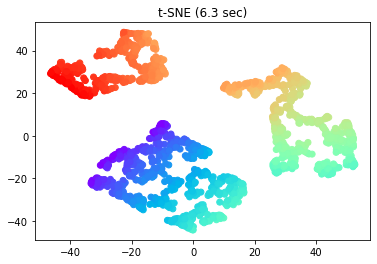

In [9]:
t0sne = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
XSNE = tsne.fit_transform(X).T
t1sne = time()

plt.scatter(XSNE[0], XSNE[1], c=color, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1sne - t0sne))
plt.axis('tight')

plt.show()


## Spike Models

One interesting question that we can ask is whether PCA is capable of finding low-dimensional structures in presence of noise. 

First assume that only noise is observed. We draw i.i.d Gaussian vector in dimension $p$ and observe $n$ samples from it.

In [10]:
# Number of vectors
n = 1000
# Dimension
from scipy.stats import norm
p = 500
X = norm.rvs(0,1,size=(p,n))

We see what is the spectral decomposition of the sample covariance matrix. The histogram of eigenvalues is plotted. 

Text(0.5, 1.0, 'Scree Plot of Eigenvalues, n=1000,p=500')

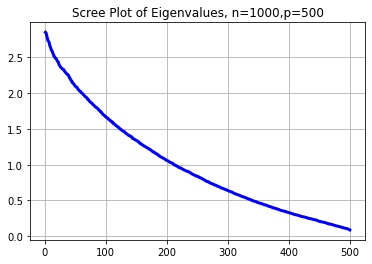

In [11]:
Sn=(X@X.transpose())/n
v, u = la.eig(Sn)
idx = v.argsort()[::-1]   # Sorting eigenvalues
vsorted = v[idx]

basex = range(1,p+1)
fig = plt.figure()
baseline = plt.plot(basex,vsorted)
plt.setp(baseline, 'color','b', 'linewidth', 3)
plt.grid(True)
plt.title('Scree Plot of Eigenvalues, n={},p={}'.format(n,p))



Interestingly, it seems that from some eigenvalues are small and it seems that there is a lower dimensional structure here. The reason is that the number of samples is small for detecting the geometry of data. Indeed the density of eigenvalues is given by the Marchenko Pastur density function.

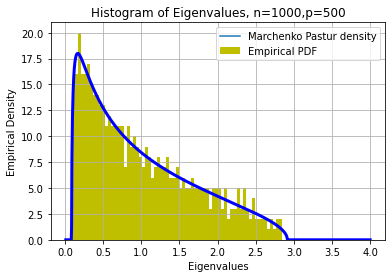

In [12]:
# the Marchenko Pastur density 
def MPden(x,p,n):
    ###    Definition of the Marchenko Pastur density 
    q = p/n
    lplus = 1+q+2*np.sqrt(q)
    lminus = 1+q-2*np.sqrt(q)
    if (lplus-x)*(x-lminus)<0:
        return 0
    return 1/(2*np.pi*x*q)*np.sqrt((lplus-x)*(x-lminus))


binsize = 20
binnum = (p/binsize)
binmax = int((vsorted[0]-vsorted[p-1])*binnum)
xaxis = np.linspace(0.01, 4, 1000)
plt2 = plt.plot(xaxis,[MPden(x,p,n)*binsize for x in xaxis], label="Marchenko Pastur density")
# Histogram
h = plt.hist(vsorted, bins=binmax, color='w', facecolor='y', label="Empirical PDF")
plt.legend()
plt.xlabel('Eigenvalues')
plt.ylabel('Empirical Density')
plt.title('Histogram of Eigenvalues, n={},p={}'.format(n,p))
plt.setp(plt2, 'color','b', 'linewidth', 3)
plt.grid(True)
plt.show()

What happens when we have a lower dimensional structure here? We assume that a one-dimensional data is added to the noise. This is called the spike model. As it can be seen below, the *power* of this one-dimensional data should be high enough so that it is detected properly.

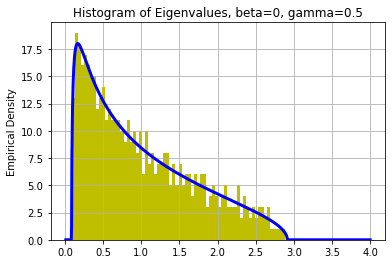

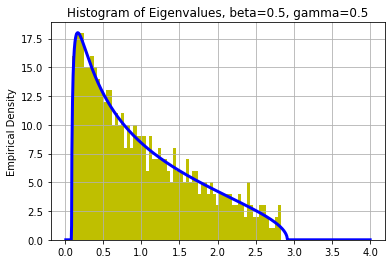

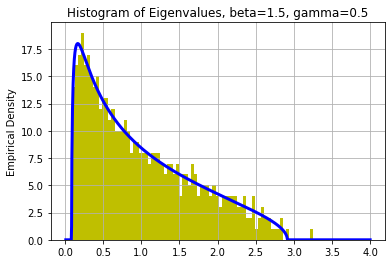

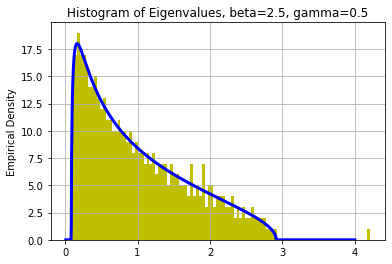

In [13]:
from scipy.stats import multivariate_normal as mvnorm

# Covariance Matrix 
gamma = p/n
Mu = np.zeros(p)
Covect = np.array(np.append([1], np.zeros(p-1)),ndmin=2)
Covect2 = np.array(np.append([0, 1], np.zeros(p-2)),ndmin=2)
beta2 = 0.5
betavector = [0, 0.5, 1.5, 2.5]
xaxis = np.linspace(0.01,4,1000)
m = len(betavector)
for beta in betavector:
    Sigma = np.eye(p)+beta*Covect.transpose()@Covect+beta2*Covect2.transpose()@Covect2
    X = mvnorm.rvs(Mu,Sigma,size=(1,n))
    Sn = (X.transpose()@X)/n
    v, u = la.eig(Sn)
    idx = v.argsort()[::-1]   # Sorting eigenvalues
    vsorted = v[idx]
    binmax = int((vsorted[0]-vsorted[p-1])*binnum)
    # Plotting Densities 
    # Marchenko Pastur density
    plt2 = plt.plot(xaxis,[binsize*MPden(x,p,n) for x in xaxis], label="Marchenko Pastur density")
    # Histogram
    h = plt.hist(vsorted, bins=binmax, color='w', facecolor='y', label="Empirical PDF")
    plt.ylabel('Empirical Density')
    plt.title(r'Histogram of Eigenvalues, beta={}, gamma={}'.format(beta,gamma))
    plt.setp(plt2, 'color','b', 'linewidth', 3)
    plt.grid(True)
    plt.show()